# **Time Series Analysis & Predictive Modelling**

For Time Series Anlaysis , we will consider one store from each store type a , b , c , d that will represent their respective group. It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import zipfile
import os

from statsmodels.tsa.stattools import adfuller # Importing the adfuller function from the statsmodels library
from statsmodels.tsa.seasonal import seasonal_decompose # Importing the seasonal_decompose function from the statsmodels library
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Set Kaggle Configuration: To direct Kaggle to the appropriate directory in Drive
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle competitions download -c rossmann-store-sales

 72% 5.00M/6.99M [00:00<00:00, 46.1MB/s]
100% 6.99M/6.99M [00:00<00:00, 58.9MB/s]


In [ ]:
# Define the path to your zip file
file_path = '/content/rossmann-store-sales.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle/rossmann-store')

In [ ]:
# Importing store data
train = pd.read_csv('/content/drive/MyDrive/kaggle/rossmann-store/train.csv', index_col='Date', parse_dates = True)
test = pd.read_csv('/content/drive/MyDrive/kaggle/rossmann-store/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/kaggle/rossmann-store/sample_submission.csv')

<ipython-input-14-ae461d28234a>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/drive/MyDrive/kaggle/rossmann-store/train.csv', index_col='Date', parse_dates = True)


In [ ]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
# train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [ ]:
# Checking train data again
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,SalePerCustomer
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,8.626118


In [ ]:
pd.plotting.register_matplotlib_converters()

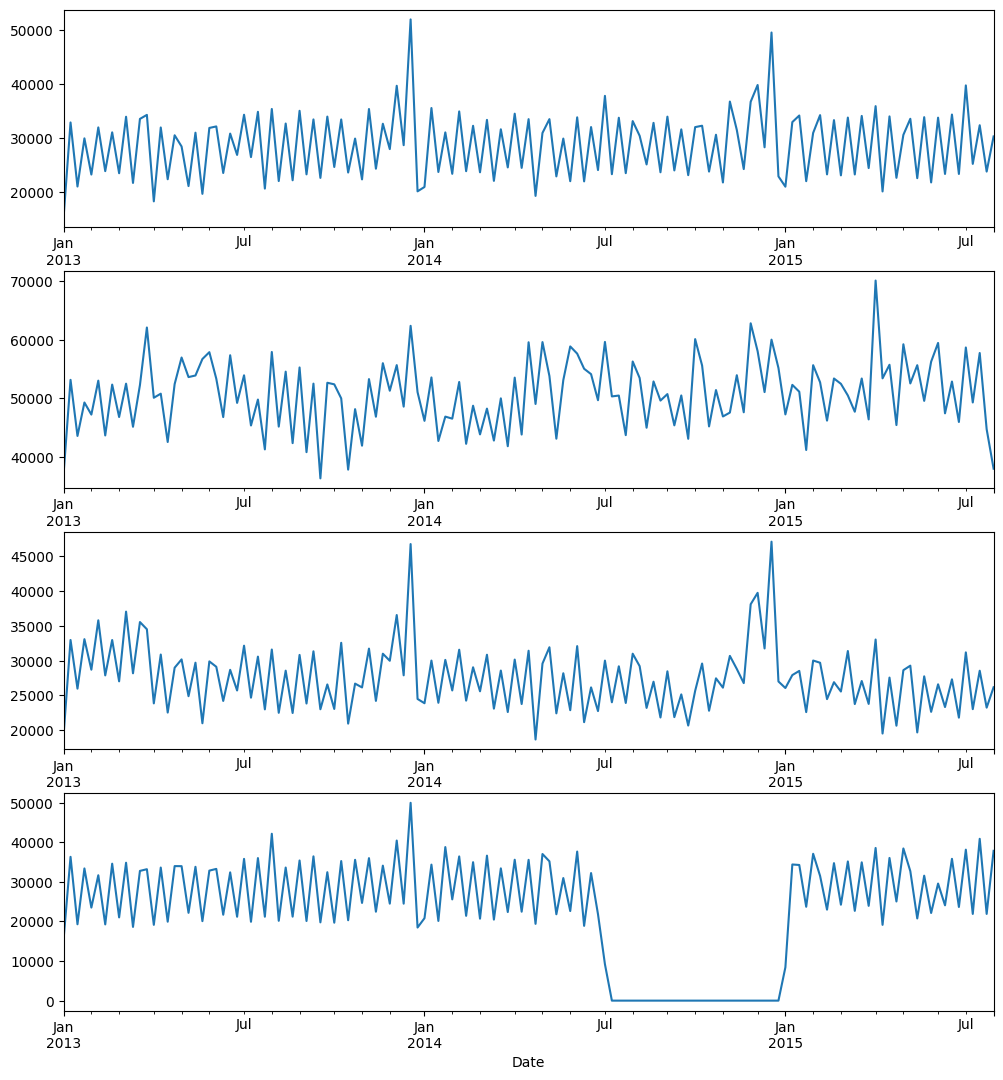

In [ ]:
#Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

We can see from above plots that sales for StoreType A and C tend to peak in the end of year (Christmas season) and then decline after the holidays. We are not able to see a similar trend in StoreType D because no data is available for that time period (stores closed)

## **Stationarity of Time Series**

In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time.

There are 2 ways to test the stationarity of time series a) Rolling Mean: Visualization b) Dicky - Fuller test: Statistical test

a) Rolling Mean: A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slid across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.

b) Dicky -Fuller test: This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [ ]:
# Function to test the stationarity
def test_stationarity(timeseries):

    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

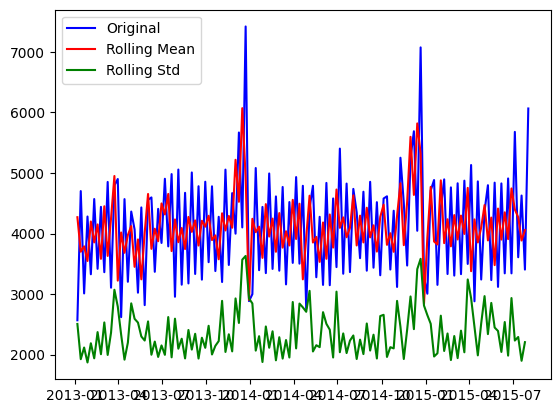

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [ ]:
# Testing stationarity of store type a
test_stationarity(sales_a)

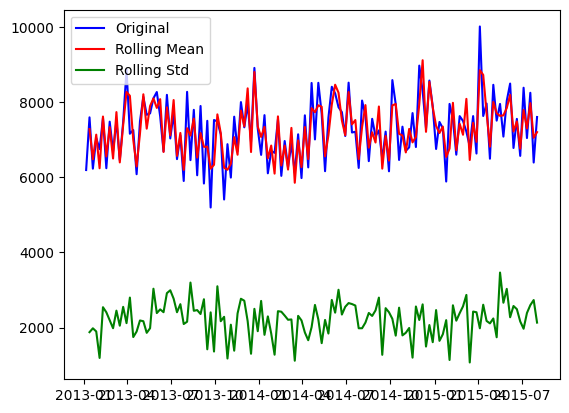

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [ ]:
#Testing stationarity of store type b
test_stationarity(sales_b)

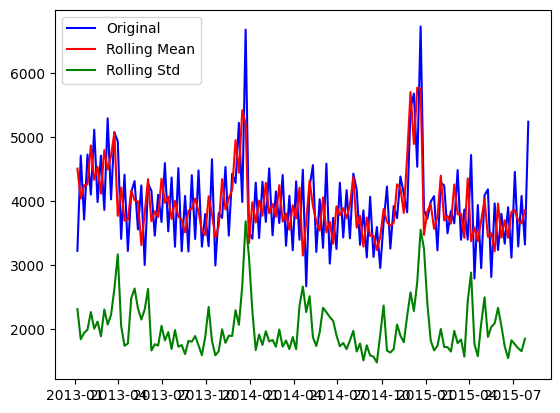

Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [ ]:
#Testing stationarity of store type b
test_stationarity(sales_c)

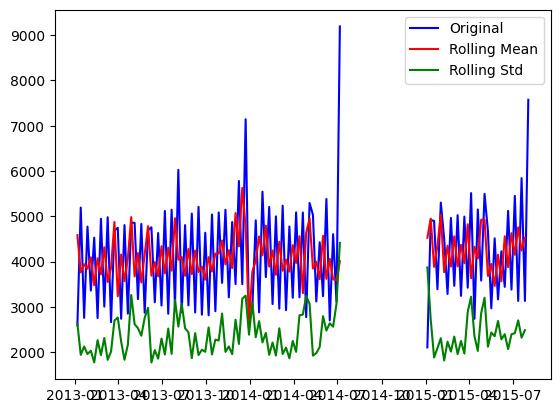

Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [ ]:
#Testing stationarity of store type d
test_stationarity(sales_d)

We can see from the above plots and statistical tests that mean and variation doesn't change much with time, i.e `they are constant`. Thus, we don't need to perform any transformation (needed when time series is not stationary).

Now, let's check the trend and seasonality in our data.

In [ ]:
def plot_timeseries(sales, StoreType):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    # Decompose the time series
    decomposition = seasonal_decompose(sales, model='additive', period=365)

    # Extract components
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal

    # Plot seasonality
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('Seasonality')

    # Plot trend
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Trend')

    # Set x-axis label and title
    plt.xlabel('Date')
    plt.suptitle(f'Decomposition Plots for StoreType: {StoreType}', fontsize=16)

    plt.tight_layout()
    plt.show()


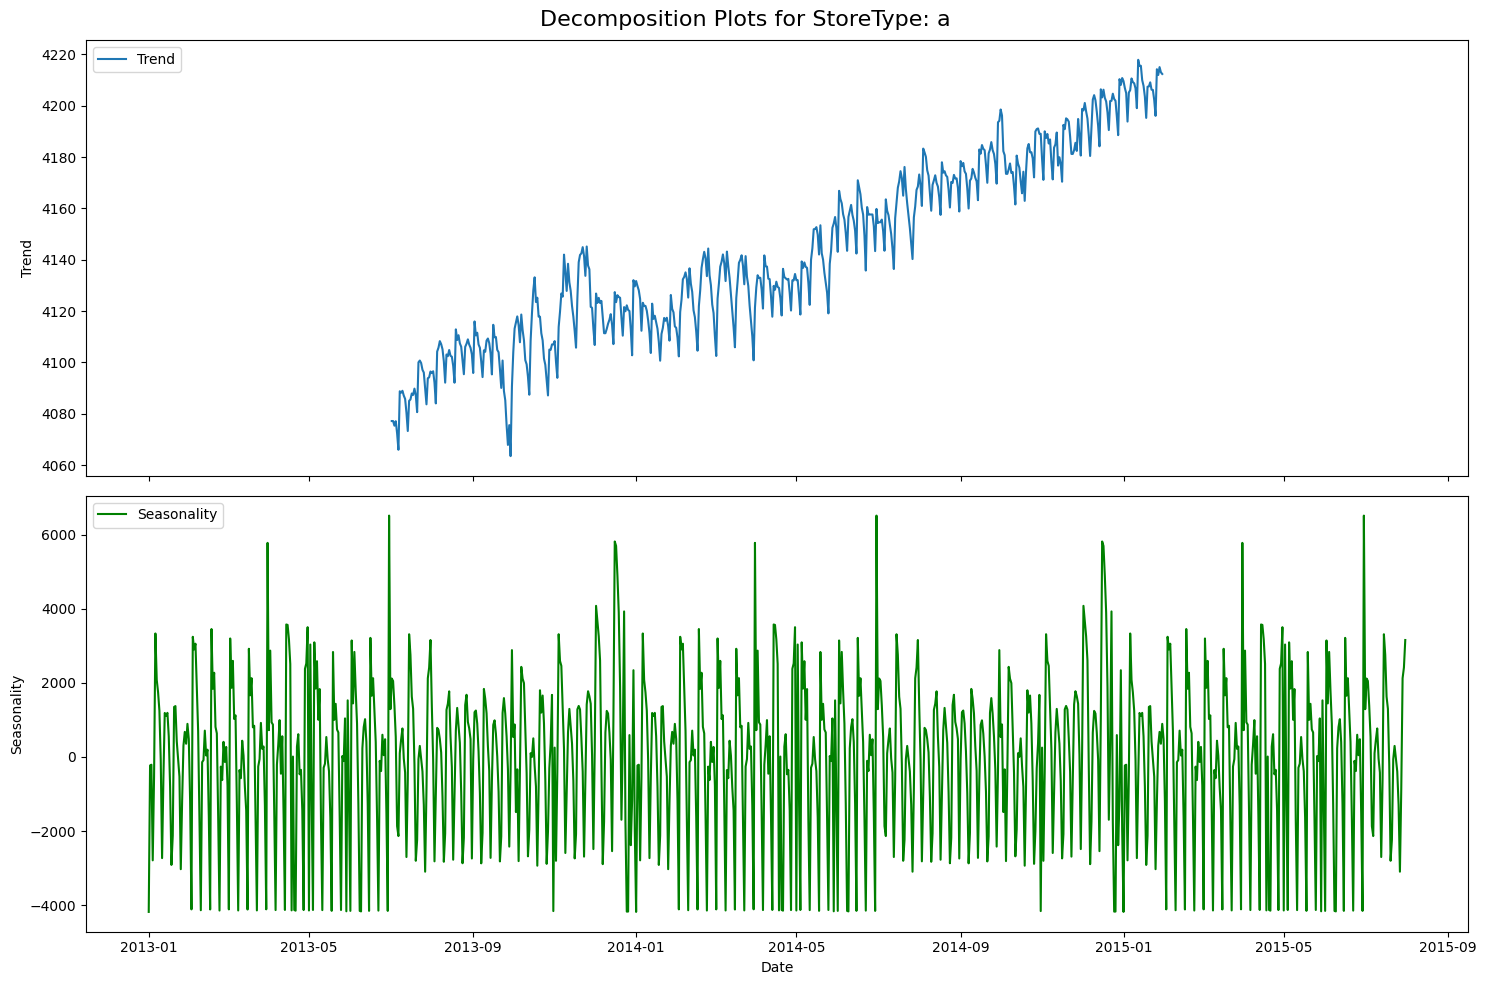

In [ ]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

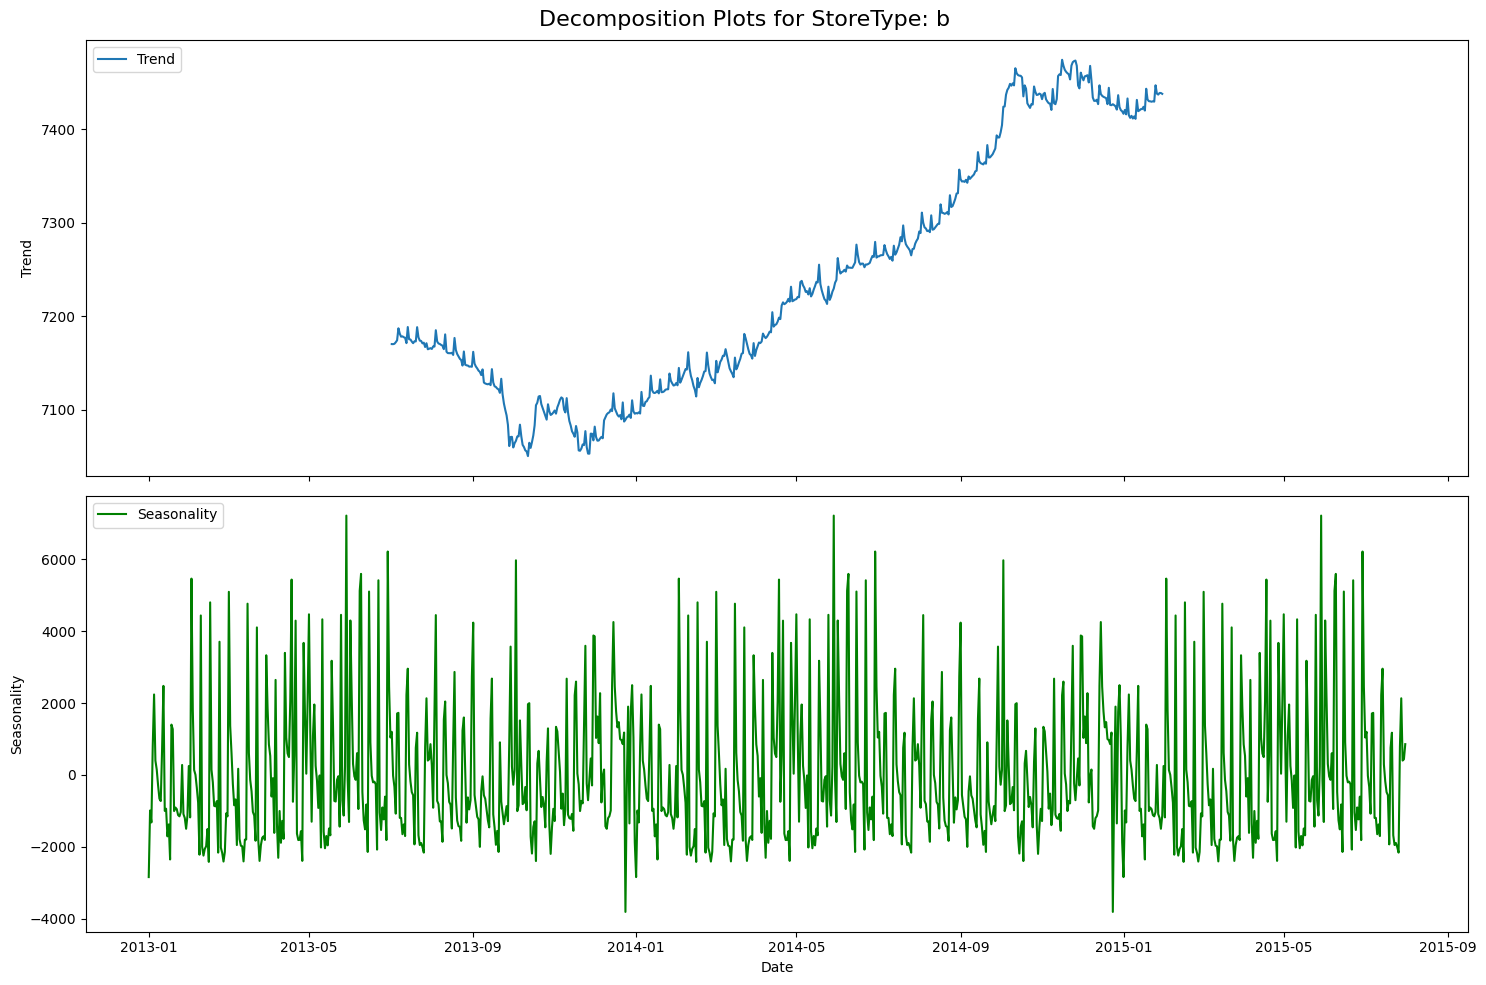

In [ ]:
# Plotting seasonality and trend for store type b
plot_timeseries(sales_b,'b')

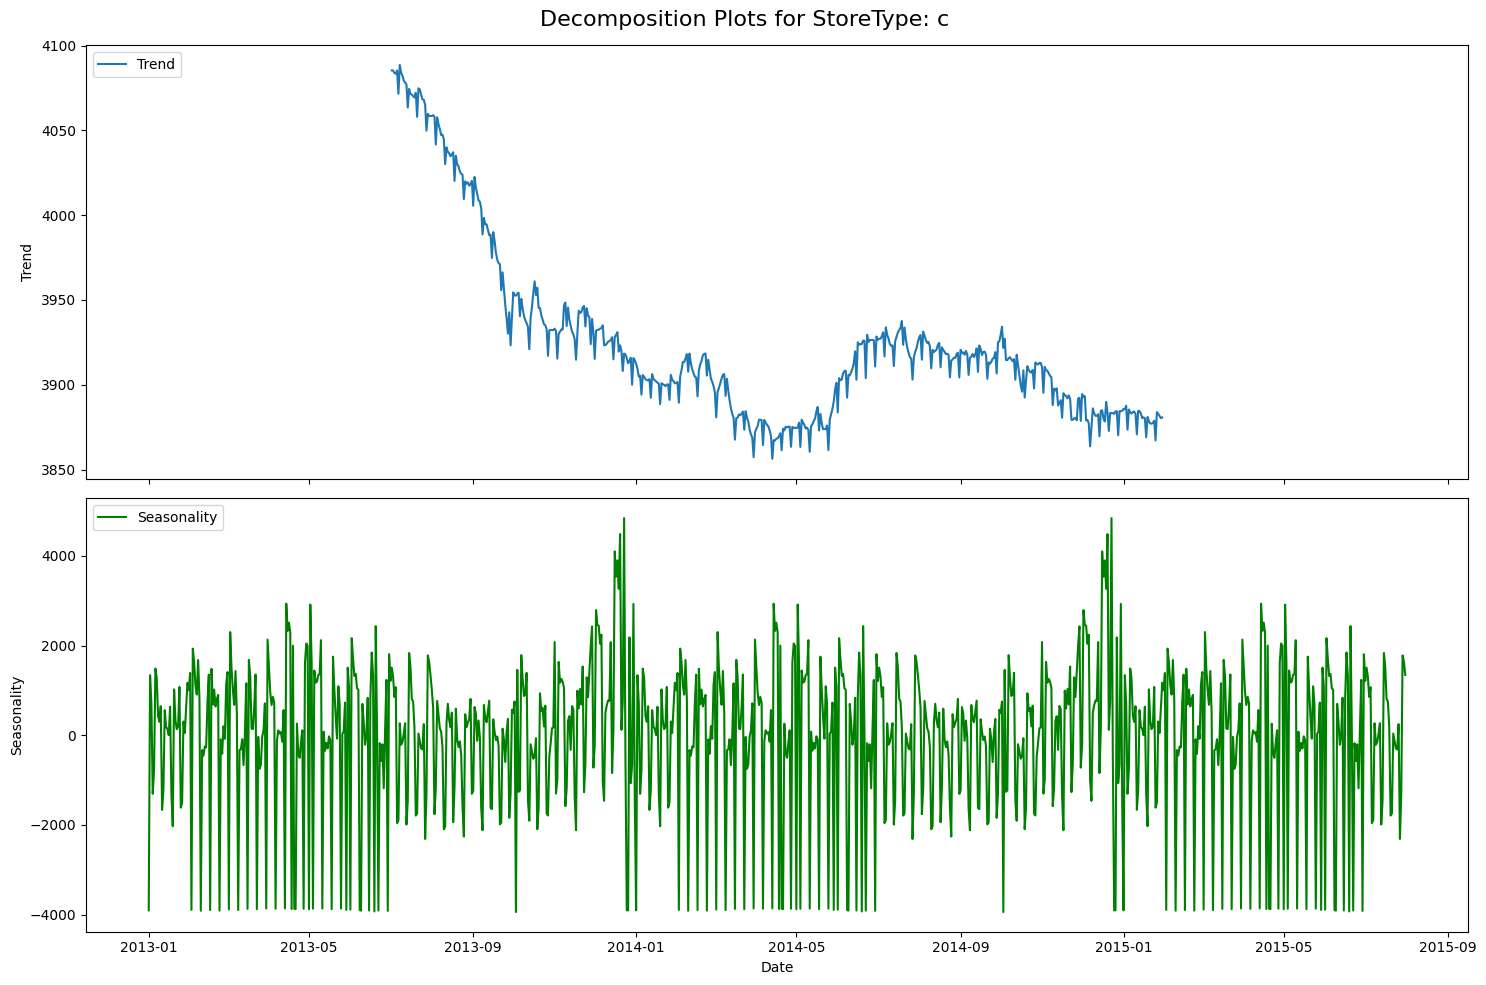

In [ ]:
# Plotting seasonality and trend for store type c
plot_timeseries(sales_c,'c')

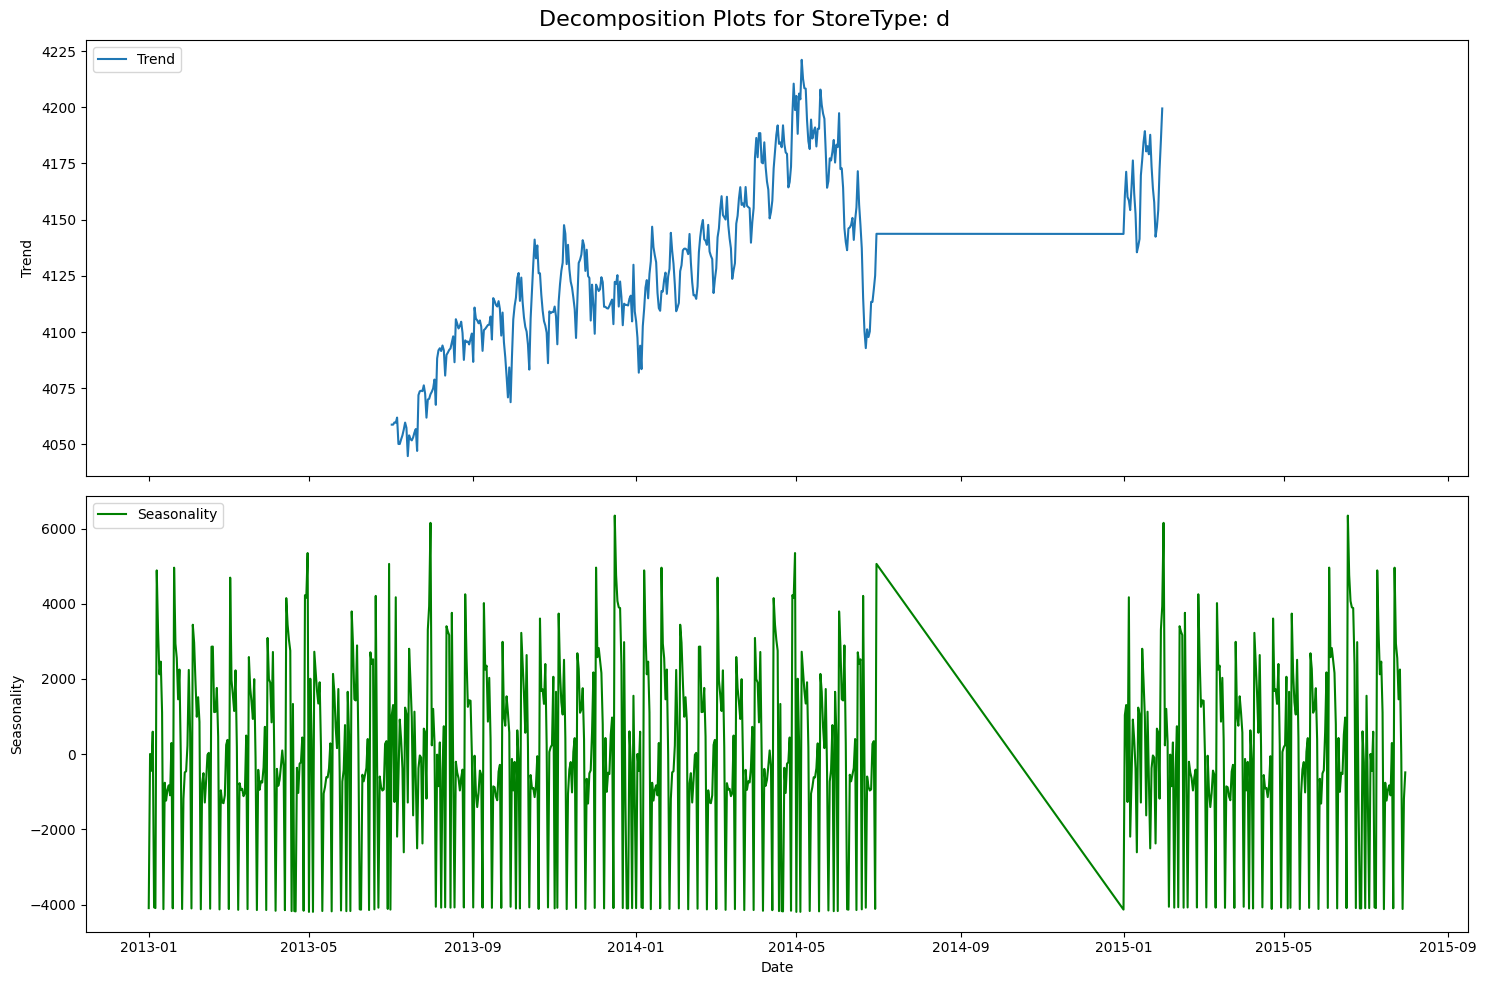

In [ ]:
# Plotting seasonality and trend for store type d
plot_timeseries(sales_d,'d')

From the above plots, we can see that there is seasonality and trend present in our data. So, we'll use forecasting models that take both of these factors into consideration. For example, `LSTM`

## **Forecasting a Time Series**

**Check for autocorrelation and partial autocorrelation of the data**

**ACF** - measure of correlation between time series with a lagged version of itself.

**PACF** - measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

In [ ]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

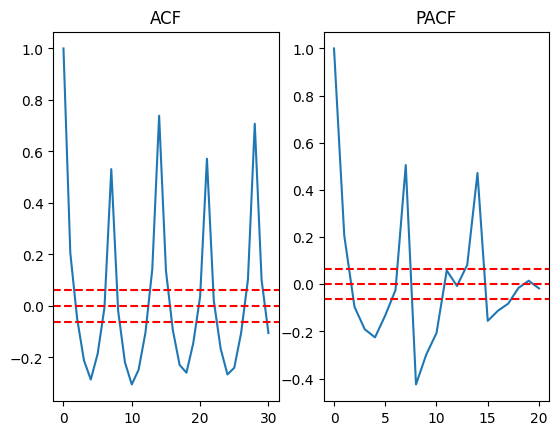

In [ ]:
# ACF and PACF for store type a
auto_corr(sales_a)

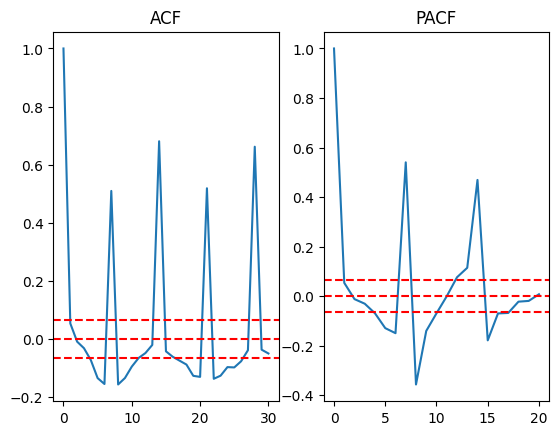

In [ ]:
# ACF and PACF for store type b
auto_corr(sales_b)

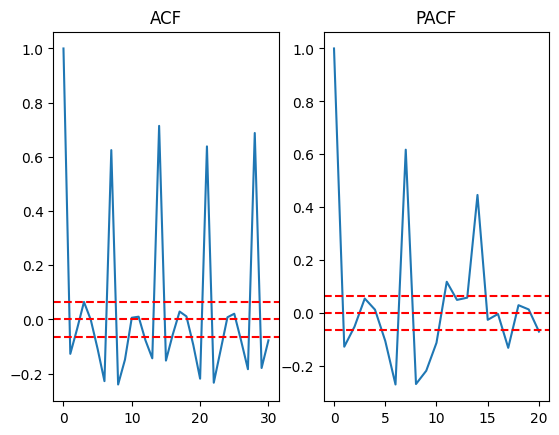

In [ ]:
# ACF and PACF for store type c
auto_corr(sales_c)

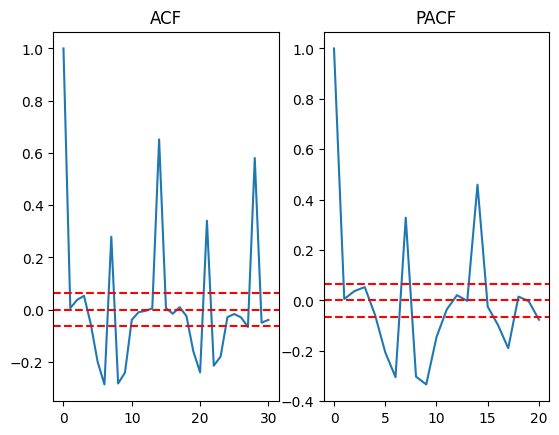

In [ ]:
# ACF and PACF for store type d
auto_corr(sales_d)

**Seasonality**:

Store Types A and B exhibit strong and regular seasonality in their sales data, as reflected by regular peaks in the ACF plots.
Store Type C shows weaker seasonality, with less consistent periodicity in its ACF, indicating potential noise or more variation in sales patterns.
Store Type D has moderate seasonality, but it is less pronounced than A and B, showing a mixed pattern of spikes in the ACF plot.

**Autoregressive Nature:**

The PACF plots for Store Types A and B suggest strong autoregressive components, indicating that a lower-order AR model might be suitable for these store types.
Store Type C's PACF is less regular, suggesting that a more complex model, such as ARMA or ARIMA, could be required to account for both autoregressive and moving average components.
Store Type D, like Store A, shows strong autocorrelation at initial lags, suggesting that a low-order AR process could effectively model its sales data.

## **Prepare the data for model training**

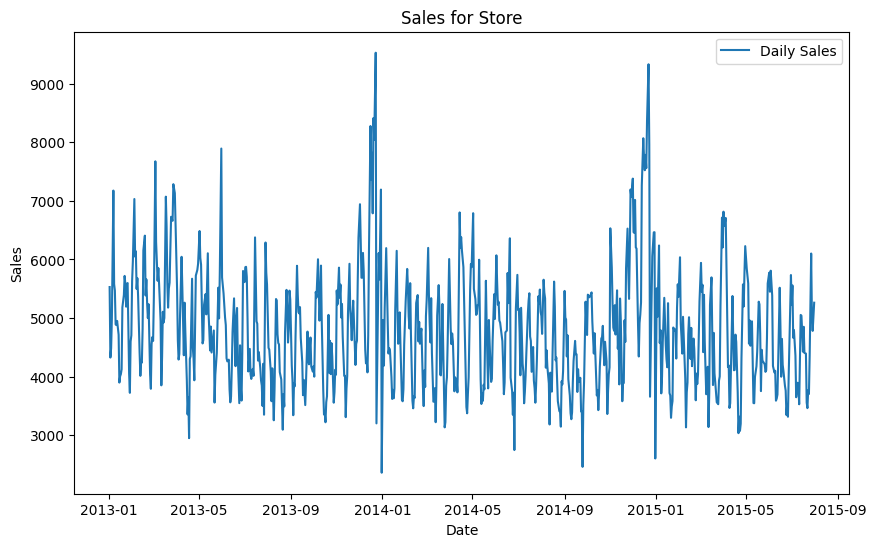

In [ ]:
# Remove closed stores and those with no sales
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

# Reset the index to make 'Date' a column
train = train.reset_index()

# Filter sales for store number 1
sales = train[train.Store == 1][['Date', 'Sales']]

# Sort in ascending order (from 2013 to 2015)
sales = sales.sort_values('Date')

# Convert 'Date' to datetime
sales['Date'] = pd.to_datetime(sales['Date'])

# Set 'Date' as index
sales.set_index('Date', inplace=True)

# Plot the sales data
plt.figure(figsize=(10, 6))
plt.plot(sales, label='Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales for Store')
plt.legend()
plt.show()

### **Data Transformation to Supervised Learning Format**

In [ ]:
# Convert time series to supervised learning format
def create_supervised_data(data, n_lags=1):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i - n_lags:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Scale data between (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = scaler.fit_transform(sales)

# Create supervised data with 7 lags (1 week of data)
n_lags = 7
X, y = create_supervised_data(scaled_sales, n_lags=n_lags)

# Reshape X to fit LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_lags, 1)))
model.add(Dense(1))  # Output layer for regression (1 value)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1855 - val_loss: 0.1602
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1382 - val_loss: 0.1112
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1064 - val_loss: 0.0679
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0699 - val_loss: 0.0518
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0707 - val_loss: 0.0494
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661 - val_loss: 0.0481
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0623 - val_loss: 0.0450
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0634 - val_loss: 0.0431
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0546 - val_loss: 0.0421
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0533 - val_loss: 0.0396
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0526 - val_loss: 0.0389
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

In [ ]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predicted and actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_pred_train_inv = scaler.inverse_transform(y_pred_train)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Train RMSE: 759.87
Test RMSE: 594.79


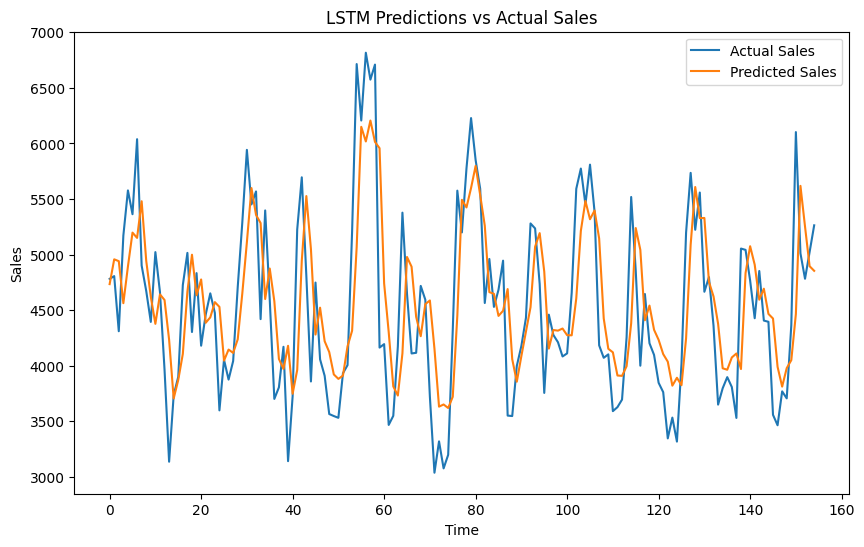

In [ ]:
# Evaluate with RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Plot predictions vs actual sales
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Sales')
plt.plot(y_pred_test_inv, label='Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('LSTM Predictions vs Actual Sales')
plt.legend()
plt.show()


The LSTM model uses past sales data (sliding window approach) to predict future sales and is trained on scaled data.



The plot you've provided compares the LSTM model's predicted sales with the actual sales over time, along with the Train RMSE (759.87) and Test RMSE (594.79), which are metrics indicating the model's error.

### **General Insights:**

**Close Alignment**: The predicted sales (orange line) closely follow the actual sales (blue line) for most of the time steps. This indicates that the LSTM model captures the general trends and seasonal patterns in the data well.

**Lower Test RMSE**: The test RMSE (594.79) is lower than the train RMSE (759.87). This suggests that the model generalizes well and performs better on unseen data (test set), possibly due to some overfitting on the training set or inherent variability in the training data.

**Capturing Peaks and Troughs**: The LSTM is effective in predicting the peaks and troughs in sales, which reflects its strength in handling both short-term fluctuations and longer-term patterns. However, some peaks and sudden changes seem slightly underestimated or delayed, which is common in time series models.

**Error Distribution**: The gaps between the predicted and actual sales appear larger in certain periods, suggesting that while the LSTM model captures the overall pattern well, there are periods where the prediction error is higher. These areas could be moments of irregular sales behavior that the model struggles with.

### **Potential Actions:**
**Hyperparameter tuning**: Further fine-tuning of the model's architecture or training parameters could help reduce the training error and make the predictions even more accurate.
**Feature Engineering**: Including additional external features (like promotions, holidays, weather) might help improve accuracy, especially in periods where the model struggles to predict spikes or drops.

In summary, the LSTM model provides good forecasting accuracy, with a relatively low error and the ability to predict sales trends effectively. However, there is room for improvement, particularly in refining predictions during volatile periods.